# Hyperparameter Inference

In this notebook we use the simulation data from the simulation tutorial to reconstruct the input dark matter mass and signal fraction.

## Imports and general setup

Let's first import everything required for this script.

In [1]:
import os, sys, time, random
from scipy import interpolate, special, integrate

from gammabayes.hyper_inference.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.priors.prior import discrete_logprior
from gammabayes.dark_matter.SS_DM_Constructor import SS_DM_dist
from gammabayes.likelihoods.instrument_response_funcs import log_bkg_CCR_dist, single_loglikelihood
from gammabayes.utils.event_axes import makelogjacob
from gammabayes.utils.config_utils import read_config_file, create_true_axes_from_config, create_recon_axes_from_config


import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

from multiprocessing import Pool, freeze_support
random.seed(0)

/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Script Parameter Setup

Just like with the simulation script we opt to use a yaml configuration file rather than specify 20+ parameters on every run. We'll extract these parameters from the config file and define a couple useful quantities, like the axes and the number of signal and background events.

In [2]:
startertimer = time.perf_counter()
print(startertimer)

config_inputs = read_config_file('example_run_script.yaml')

nsig                = int(round(config_inputs['xi']*config_inputs['Nevents']))
nbkg                = int(round((1-config_inputs['xi'])*config_inputs['Nevents']))


log10_eaxis_true, longitude_axis_true, latitude_axis_true = create_true_axes_from_config(config_inputs)
log10_eaxis, longitude_axis, latitude_axis = create_recon_axes_from_config(config_inputs)


log10_mass = config_inputs['logmass']


log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10_eaxis_true, longitude_axis_true, latitude_axis_true, indexing='ij')
lonmeshtrue, latmeshtrue = np.meshgrid(longitude_axis_true, latitude_axis_true, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitude_axis, latitude_axis, indexing='ij')
logjacobtrue = np.meshgrid(np.log(10**log10_eaxis_true), longitude_axis_true, latitude_axis_true, indexing='ij')[0]


config_inputs

612799.313221708
file path: example_run_script.yaml
-1 2 150 0.2 -3.5 3.5 -3.0 3.0
-1 2 60 0.4 -3.5 3.5 -3.0 3.0


{'identifier': 'example_config_run',
 'Nevents': 1000,
 'logmass': 1.0,
 'xi': 0.5,
 'nbins_logmass': 101,
 'nbins_xi': 161,
 'dmdensity_profile': 'einasto',
 'numcores': 8,
 'runnumber': 3,
 'totalevents': 1000,
 'batch_job': 0,
 'log10_true_energy_min': -1,
 'log10_true_energy_max': 2,
 'log10_true_energy_bins_per_decade': 150,
 'true_spatial_res': 0.2,
 'true_longitude_min': -3.5,
 'true_longitude_max': 3.5,
 'true_latitude_min': -3.0,
 'true_latitude_max': 3.0,
 'log10_recon_energy_min': -1,
 'log10_recon_energy_max': 2,
 'log10_recon_energy_bins_per_decade': 60,
 'recon_spatial_res': 0.4,
 'recon_longitude_min': -3.5,
 'recon_longitude_max': 3.5,
 'recon_latitude_min': -3.0,
 'recon_latitude_max': 3.0}

The output of the cell should show all the relevant inputs from the config file.

# <h1><b>Simulation Result Loading

Let's first define the priors we'll need, it is recommended to use the same ones that went into the simulation otherwise you'll get wack results.

In [3]:

SS_DM_dist_instance= SS_DM_dist(longitude_axis_true, latitude_axis_true)#, density_profile=config_inputs['dmdensity_profile'])
logDMpriorfunc = SS_DM_dist_instance.func_setup()

logjacob_true = np.meshgrid(makelogjacob(log10_eaxis_true), longitude_axis_true, latitude_axis_true, indexing='ij')[0]

DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['log10 energy', 'lon', 'lat'],
                               default_hyperparameter_values=(log10_mass,), 
                               hyperparameter_names=['mass'], logjacob=logjacob_true)
DM_prior

(1.0,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x154a03b00>
input units of None
over axes ['log10 energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

In [4]:
from scipy import special, interpolate
from gammabayes.utils.default_file_setup import default_file_setup

nuisancemesh = np.meshgrid(log10_eaxis_true, longitude_axis_true, latitude_axis_true, indexing='ij')

astrophysicalbackground = default_file_setup(setup_astrobkg=1, setup_irfnormalisations=0,
                                log10eaxistrue=log10_eaxis_true, longitudeaxistrue=longitude_axis_true, latitudeaxistrue=latitude_axis_true, 
                                save_results=False, outputresults=True)
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(log_bkg_CCR_dist(*nuisancemesh)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacob_true)

logbkgpriorvalues.shape




unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(log_bkg_CCR_dist(*nuisancemesh)),np.log(astrophysicalbackground))
# unnormed_logbkgpriorvalues = np.squeeze(bkgdist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10_eaxis_true, longitude_axis_true, latitude_axis_true,), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['log10 energy', 'lon', 'lat'], logjacob=logjacob_true)

bkg_prior

Setting up the astrophysical background


Setting up HESS sources



/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)



There are 96 sources in total within the HGPS.
Including point sources.
Done setup, results saved to package_data. Accessible through `load_package_data`(.py) 
    or through `resource_dir` variable in utils.


discrete log prior class
----------------------------
name = Background Prior
logfunction type is <function <lambda> at 0x154ad5f80>
input units of None
over axes ['log10 energy', 'lon', 'lat']
with hyperparameter(s) [None]

For the analysis, we also require the normalisation values of the IRFs to reduce memory loads. Different methods for computers with larger RAM capabilities is being developed that will hopefully cause an increase in speed from a factor of 100 to 1000.

In [5]:
psfnormalisationvalues, edispnormalisationvalues = default_file_setup(setup_astrobkg=0, setup_irfnormalisations=1,
                                log10eaxistrue=log10_eaxis_true, longitudeaxistrue=longitude_axis_true, latitudeaxistrue=latitude_axis_true, 
                                save_results=False, outputresults=True)

Setting up edisp normalisation: 100%|█████████| 451/451 [00:13<00:00, 34.33it/s]


Now we will load the actual measured or reconstructed values from the simulations and group them to a single set of 'measured' values like you would expect from CTA observations.

In [6]:
bkg_log10e_measured, bkg_lon_measured, bkg_lat_measured = np.load(f'tutorial_data/recon_bkg_samples.npy')
signal_log10e_measured, signal_lon_measured, signal_lat_measured = np.load(f'tutorial_data/recon_sig_samples.npy')

try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

Now we can start the actual analysis.

# <h1><b>Analysis

## Marginalisation

To get a discrete posterior in mass we need some discrete values of mass to test our data with. In the below cell we have made it so values from 0.1TeV to 100TeV will be tested. If you wish to 'zoom in' and not waste time on points of zero probability we can cheat a little and uncomment the currently commented lines to create a 'window' that is centred around the true values.

In [7]:


logmasswindowwidth      = 12/np.sqrt(config_inputs['xi']*config_inputs['totalevents'])

logmasslowerbound       = config_inputs['logmass']-logmasswindowwidth
logmassupperbound       = config_inputs['logmass']+logmasswindowwidth

# Comment these two lines if you uncomment the others
logmasslowerbound = log10_eaxis_true[0]
logmassupperbound = 2


# The log10 mass values we will test
logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, config_inputs['nbins_logmass']) 

From here we will start using the `hyperparameter_likelihood` class which currently handles most of the hyperparameter inference we will do. It takes in similar inputs to the prior classes with of course the addition of the priors to be evaluated and the likelihood function to be used. The `likelihood` input should take a function that takes in the the axes and dependent axes and outputs the log-likelihood for those values. 

The class additionally takes in the normalisation for this likelihood as it is hard to maintain normalisation with interpolation which is generally what is done with the CTA IRFs/likelihood as they are generated stochastically and thus have no analytical form.

In [8]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(
                                                               priors=(DM_prior, bkg_prior,), likelihood=single_loglikelihood, 
                                                               dependent_axes=(log10_eaxis_true,  longitude_axis_true, latitude_axis_true), 
                                                               dependent_logjacob=logjacob_true,
                                                               hyperparameter_axes = ((logmassrange,), (None,)), numcores=config_inputs['numcores'], 
                                                               likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)



Once we've instantiated the class we can then use the `nuisance_log_marginalisation` class method to return the log likelihood values after marginalising over the nuisance/true values.

In [9]:
measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
log_margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(
    axisvals= (measured_log10e, measured_lon, measured_lat),)

Setting up prior matrices: 100%|██████████| 2/2 [01:30<00:00, 45.13s/it]
Performing parallelized direct event marginalisation: 100%|██████████| 1000/1000 [00:00<00:00, 213363.72it/s]
/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammabayes/likelihoods/instrument_response_funcs.py:53: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammabayes/likelihoods/instrument_response_funcs.py:57: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


KeyboardInterrupt: 

Let's put the result into a numpy array and extract the marginalisation values for the background and the signal respectively.

In [ ]:
log_margresultsarray = np.array(log_margresults)
log_sigmargresults = np.squeeze(np.vstack(log_margresultsarray[:,0])).T
log_bkgmargresults = np.squeeze(np.vstack(log_margresultsarray[:,1]))
log_sigmargresults.shape

(101, 1000)

Now we have the log signal marginalisation results we can look at the log mass probability densities for each event. It's not needed but it looks nice!

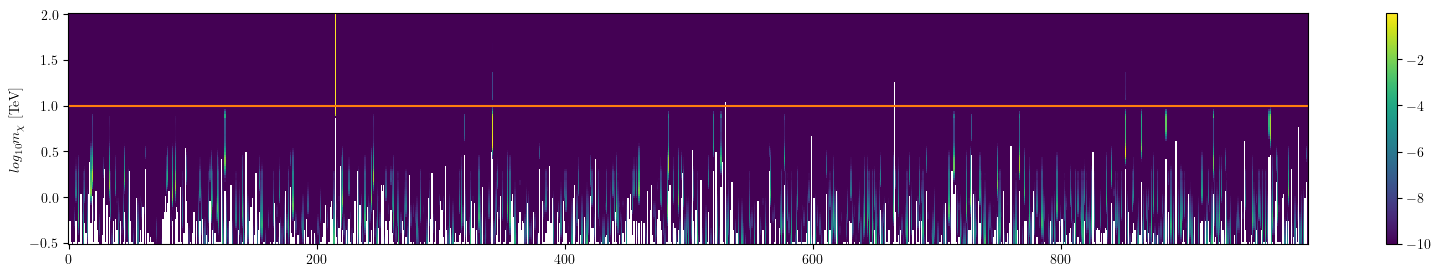

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(config_inputs['Nevents'])), logmassrange, indexing='ij'), 
               log_sigmargresults.T-special.logsumexp(log_sigmargresults, axis=1), 
               cmap='viridis', vmin=-10)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(config_inputs['logmass'], c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

Similar to what we did with the logmass 'window' we can do the same with the signal fraction. Uncomment the relevant code to make a zoomed in window of values to test.

In [ ]:
lambdawindowwidth      = 6/np.sqrt(config_inputs['totalevents'])


lambdalowerbound       = config_inputs['xi']-lambdawindowwidth
lambdaupperbound       = config_inputs['xi']+lambdawindowwidth




if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, config_inputs['nbins_xi']) 



We can then use the `create_mixture_log_hyperparameter_likelihood` class method to calculate the hyperparameter likelihood, not posterior as we haven't applied the priors, although we choose them to be relatively uninformative for the mass and signal fraction so the total result won't change. Essentially we put in the `mixture_axes`, should be one for each components and the sum of the values for each component should add to 1, and then the log marginalisation results from the previous step. if they are alreadu stored within the class instance than the method will use the defaults.


This should take only a few seconds at most for up to ~10000 events.

In [ ]:
log_hyperlikelihood = hyperparameter_likelihood_instance.create_mixture_log_hyper_likelihood(
    mixture_axes=(lambdarange, 1-lambdarange), log_margresults=log_margresultsarray)

log_hyperlikelihood = np.squeeze(log_hyperlikelihood - special.logsumexp(log_hyperlikelihood))

endertimer = time.perf_counter()
print(endertimer-startertimer)

Reshaped mixture shape: (2, 1000)
reshaped_log_margresults[0,:]: [array([           -inf,            -inf,            -inf,            -inf,
                   -inf,            -inf,            -inf,            -inf,
                   -inf,            -inf,            -inf,            -inf,
                   -inf,            -inf, -7.14790285e+02, -7.14969093e+02,
        -7.15179800e+02, -7.15333822e+02, -7.15490840e+02, -7.15627133e+02,
        -6.30343255e+00, -4.74478025e+00, -3.42900574e+00, -1.44694804e+00,
         1.64783400e-01,  1.75959726e+00,  2.98734547e+00,  3.75446571e+00,
         3.89908353e+00,  3.47534776e+00,  3.23819278e+00,  3.12406708e+00,
         3.00392384e+00,  2.89219471e+00,  2.79466624e+00,  2.71688283e+00,
         2.66299436e+00,  2.62876713e+00,  2.61505358e+00,  2.61650662e+00,
         2.62882094e+00,  2.64868405e+00,  2.67553829e+00,  2.70493166e+00,
         2.73740365e+00,  2.77058821e+00,  2.80661037e+00,  2.84412957e+00,
         2.88451765e+00

# <h1><b>Plotting

Now let's have a look at the result with another class method `plot_posterior`, although we're going to be putting in the hyperparameter log likelihood instead, but again, with normalisation the priors would cancel out anyways.

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_66070/2510690178.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


l  0.13993078646245083 -3
l  0.09486832980505144 -2
l  0.04743416490252572 -1
l  0.045062456657399386 1
l  0.08775320506967255 2
l  0.11384199576606158 3


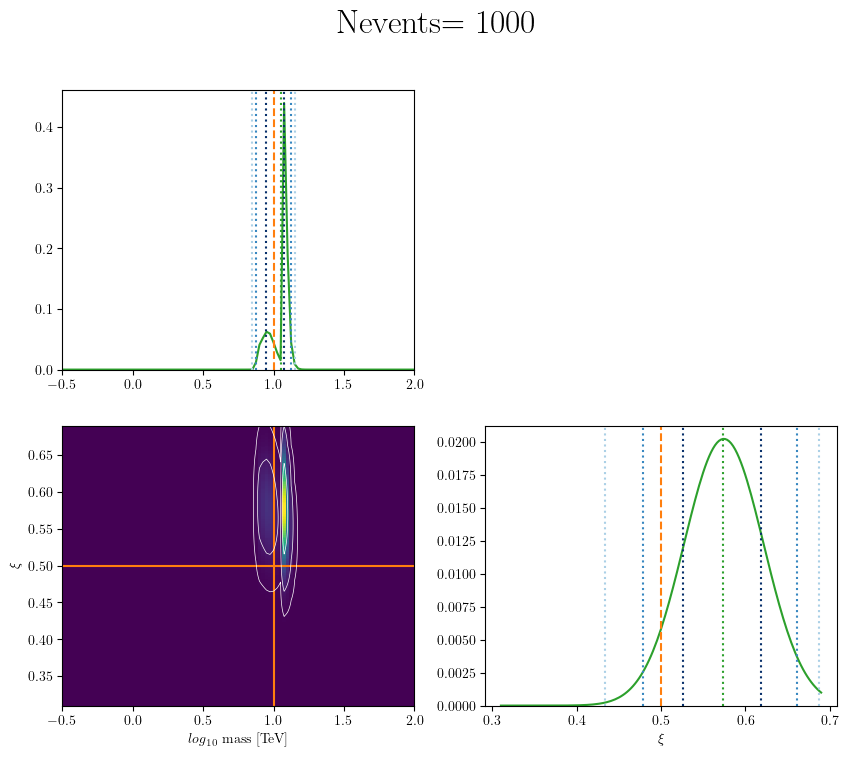

In [ ]:
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {config_inputs['Nevents']}", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_hyperlikelihood, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(config_inputs['logmass'], ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10_eaxis_true[1]-log10_eaxis_true[0]:
    for logetrueval in log10_eaxis_true:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_hyperlikelihood), vmin=0)
ax[1,0].axvline(config_inputs['logmass'], c='tab:orange')
ax[1,0].axhline(config_inputs['xi'], c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_hyperlikelihood)/np.exp(log_hyperlikelihood).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_hyperlikelihood, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print("l ", np.abs(lambdapercentile - meanlambda), zscore)





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(config_inputs['xi'], ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmass}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

The standard result should have the cross between the vertical and horizontal lines fall within the first or second white ellipse. If you're 'lucky' it will fall outside the second but within the third. 

If the intersection falls outside the third white ellipse then you've either encoutnered a statistical miracle or something has gone horribly wrong.